In [107]:
import numpy as np
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import copy 

def lowrank_missing(A, p, k, noise=0.0):
    """
    Generates an image A' where we have the rank k and missing entries.
    The given entries have optional noise.
    
    Input:
        A: the image we wish to corrupt.
        p: the probability that a given entry is missing in the final image.
        k: the rank of the final corrupted image.
        noise: the additive noise factor for our given entries. We assume that 
                our noise satisfies the normal distribution N(0,noise).
    Output:
        mask_rec: matrix of the corrupted image.
        mask: matrix with boolean values that indicates if the correspondent pixel is known
              in the corrupted image.
    """
    m, n = A.shape
    min_dim = min(m,n)
    mask = np.random.choice(np.arange(0,2), p=[p, 1-p], size=(m,n))
    noise_matrix = np.random.normal(loc=0, scale = noise, size=(m,n))
    A_masked = np.multiply(A + noise_matrix,mask)
    U, s, VT = np.linalg.svd(A_masked, full_matrices=True )
    r = rank(A_masked)
    s[min_dim-k:] = 0
    S = np.zeros((m, n), dtype=np.float)
    S[:min_dim, :min_dim] = np.diag(s)
    mask_rec = U@(S@VT)
    
    return (mask_rec, mask)

def shrinkage_threshold(x, alpha):
    """
    Applies the shrinkage/soft-threshold operator given a vector and a threshold.
    It's defined in the equation 1.5 in the paper of FISTA.
    
    Input:
        x: vector to apply the soft-threshold operator.
        alpha: threshold.
    Output:
        x_out: vector after applying the soft-threshold operator.
    """
    x_sgn  = np.sign(x)
    x_plus = np.maximum(np.absolute(x) - alpha, np.zeros_like(x))
    x_out  = np.multiply (x_plus, x_sgn)
    
    return x_out

def singular_value_shrinkage(X, alpha):
    """
    Performs the called singular value shrinkage defined in the equation 2.2 
    in the paper from Candes.
    
    Input:
        X: matrix to apply the singular value shrinkage operator.
        alpha: threshold.
    Output:
        X_out: matrix after applying the singular value shrinkage operator.
    """
    U, s, VT = np.linalg.svd(X, full_matrices=True)
    s_shth = shrinkage_threshold(s, alpha)
    S = np.zeros_like(X)
    np.fill_diagonal(S, s_shth)
    X_out = U@(S@VT)
    
    return X_out

def FISTA(X, omega, alpha, n_iter):
    """
    Performs the Fast Iterative Shrinkage-Thresholding Algorithm (FISTA) defined
    in the paper of FISTA adapted to the problem of matrix completion.
    
    Input:
        X: noisy matrix.
        omega: set of indexes whith the known values of the matrix X.
        alpha: threshold for the singular value shrinkage operator.
        n_iter: Number of iteration that the algorithm executes.
    Output:
        X_k: reconstructed matrix after n_iter iterations of the algorithm.
    """
    X_kminus1 = copy.deepcopy(X)
    Y_k = copy.deepcopy(X)
    t_k = 1
    for k in range(n_iter):
        Y_k[omega] = X[omega]
        X_k = singular_value_shrinkage(Y_k, alpha)
        t_kplus1 = (1 + np.sqrt(1+4*t_k**2))/2
        Y_k = X_k + ((t_k-1)/t_kplus1)*(X_k - X_kminus1)
        X_kminus1 = X_k
        t_k = t_kplus1  
        
    return X_k

def plot_image (image, title, cmap):
    """
    Plots an image given the matrix in a numpy array.
    
    Input:
        X: image embedded in a numpy array.
        title: title of the plot.
        cmap: color map of the image.
    Output:
        None
    """
    plt.matshow(image, cmap=cmap)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    return None
    

Shape of original image: (394, 700)


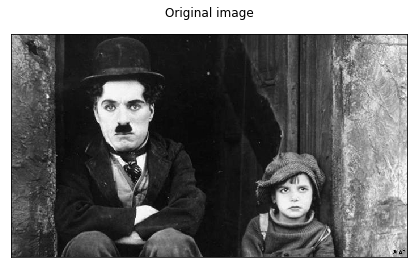

Corrupting the image...


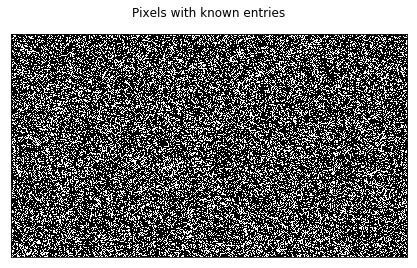

Shape of corrupted image: (394, 700)


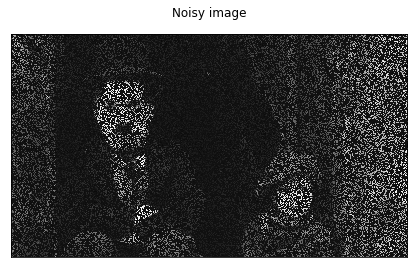

In [108]:
# path of the image
path = "./images/chaplin.jpg"
# load the image
image = Image.open(path).convert('L')
# convert image to numpy array
A = asarray(image)
m, n = A.shape
# sanity check
print("Shape of original image: {}".format(A.shape))
# plot image
plot_image(A, "Original image", "gray")
# define the rank of the final corrupted image 
k = 33
# define the probability that a given entry is missing in the final image
prob = 0.70
# corrupt the image
print ("Corrupting the image...")
A_noisy, mask = lowrank_missing(A, prob, k)
plot_image(mask, "Pixels with known entries", "gray")
# sanity check
print("Shape of corrupted image: {}".format(A_noisy.shape))
plot_image(A_noisy, "Noisy image", "gray")

### Image reconstruction in the noisy case via FISTA

Shape of reconstructed image: (394, 700)


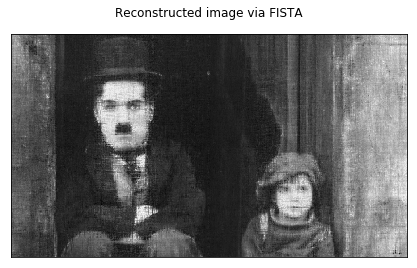

In [109]:
# get the indexes where the observed values are
omega = np.where(mask!=0)
# reconstruct the image via FISTA
X_reconstructed = FISTA(A_noisy, omega, 10, 200)
# sanity check
print ("Shape of reconstructed image: {}".format(X_reconstructed.shape))
# plot image reconstructed
plot_image(X_reconstructed, "Reconstructed image via FISTA", "gray")

In [111]:
print(X_reconstructed.min(), X_reconstructed.max())

-18.163943628812707 266.6637501115374


### Image reconstruction in the noiseless case via DRS

We are trying to solve the minimization problem $$\min_X ||X||_* \ \ \ s. t. \ \ \ AX = B$$
This can be done via Douglas-Rachford splitting. For a derivation see the report.

$$
\begin{cases}
    x^{(k+1)} = \text{Prox}_f^\gamma (z^{(k)})\\
    g^{(k+1)} = \text{Prox}_g^\gamma (2x^{(k+1)} - z^{(k)})\\
    z^{(k+1)} = z^{(k)} + y^{(k+1)} - x^{(k+1)}
\end{cases}
$$

In [198]:
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv

def D(X, gamma, m, n):
    """
    Applies the singular value thresholding operator given a vector, 
    which contains the matrix entries flattened.
    Input:
        X: unidimensional vector that represents the flattened matrix.
        gamma: threshold.
        m, n: dimensions of the matrix.
    Output:
        Xt: unidimensional vector that represents the flattened matrix after applying the
            singular value shrinkage operator.
    """
    X_ = X.reshape((m,n))
    Xt = singular_value_shrinkage (X_, gamma)
    Xt = Xt.reshape(m*n)
    
    return Xt

def draw(vec, m, n, title="", xlabel="", ylabel=""):
    """
    Plots the image given a flattened vector with the respective entries of the image.
    Input:
        vec: unidimensional vector that represents the flattened matrix.
        m, n: dimensions of the matrix.
    Output:
        None.
    """
    mat = vec.reshape((m,n))
    plt.matshow(mat, cmap="gray")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    
def draw_mat(mat, title="", xlabel="", ylabel=""):
    """
    Plots the image given a flattened vector with the respective entries of the image.
    Input:
        vec: unidimensional vector that represents the flattened matrix.
        m, n: dimensions of the matrix.
    Output:
        None.
    """
    plt.matshow(mat, cmap="gray")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def flatten(omega, n):
    """
    Transforms the index set omega ( which stores the elements which are nonzero in the corrupted image )
    into a vector-index representation.
    Input:
        omega: index set omega.
        n: second dimension of the matrix.
    Output:
        flattened: representation of the index set omega in one dimension.
    """
    flattened = []
    for coord in omega:
        i,j = coord
        flattened.append(i*n + j)
    
    return flattened
    
def construct_A(omega, m, n):
    """
    Construct the matrix A, that encodes the known entries.
    Input:
        omega: index set omega.
        m, n: dimensions of the matrix.
    Output:
        A: matrix A, that encodes the known entries.
    """
    omega_flat = flatten(omega, n)
    p = len(omega_flat) 
    row = np.arange(p)
    col = omega_flat
    data = np.ones(p)
    A = csc_matrix((data, (row, col)), shape=(p, m*n))
    
    return A

def DRS(A, m, n, iterations, gamma):
    """
    Performs the Douglas–Rachford Splitting algorithm.
    Input:
        A: matrix A, that encodes the known entries.
        iteration: number of iterations to perform in the algorithm.
        gamma: threshold.
    Output:
        zk: unidimensional vector with the final approximation.
    """
    zk = np.zeros(m*n)
    for k in range(0, iterations):
        xk = zk + A.T @ (B - A@zk)
        
        yk = D(2*xk - zk, gamma, m, n)
        zk = zk + yk - xk
    
    return zk

B shape :  (82905,)
A shape:  (82905, 275800)
(82905,)


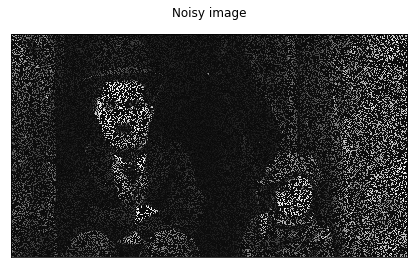

In [47]:
# get the values and the indexes of the known entries
omegaval = np.where(mask!=0)
omega = np.argwhere(mask!=0)
m, n = A_noisy.shape

# define the unidimensional vector B with the known entries
B = A_noisy[omegaval]
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
draw(A_noisy, m, n, "Noisy image")
# run the DRS algorithm
rec = DRS(A, m, n, iterations = 1000, gamma = 20)
# plot the reconstructed image
draw(rec, m, n, "Reconstructed image")

# Netflix problem
Now we apply our algorithms to the netflix problem, i.e. predicting ratings for unrated movies

In [146]:
import os
import tarfile
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import numpy as np


def parse_customer_data(chunk):
    """
    Helper function to turn the customer data into usable data.
    Each line in our chunk corresponds to a rating from a customer
    and its date in the following format:
    CustomerID, Rating, Date
    
    returns:
        List of tuples containing the two elements 
        (CustomerID: int, Raring: int)
    """
    
    dat = []
    for cust_rating in chunk.split("\\n"):
        rating_data = cust_rating.split(",")
        if len(rating_data) == 3:
            
            customer_id, rating = map(int, rating_data[:2])
            
            #print(cust_rating, customer_id, rating)
            dat.append((customer_id, rating))
            
    return dat

def get_netflix_matrix(path, movie_id_range, customer_id_range, noise=0.0):
    """
    This generates the sparse netflix matrix, where the entries B_ij are the ratings
    of a movie j of customer i.
    
    Since the matrix is very big, we can specify a range of possible movie and customer
    values.
    
    Input:
        path: the path leading to the netflix .tar training file
        movie_id_range: a 2-tuple with min and max values for the movie id
              Movie ids range from 1 to 17770 sequentially
        customer_id_range: a 2-tuple with min and max values for the customer id
              CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users
    Output:
        B: the netflix matrix in sparse form (scipy.csc_matrix)
        mask: matrix with boolean values that indicates if the corresponding entry is known
              in the corrupted image (scipy.csc_matrix)
        customer_id_mapping: The mapping which maps a true user id to some smaller id.
              This mapping is necessary if the true user id needs to be recovered later.
    """
    
    assert 1 <= movie_id_range[0] and movie_id_range[1] <= 17770
    assert 1 <= customer_id_range[0] and customer_id_range[1] <= 2649429
    
    # since there are gaps in the user ids, we want to eliminate the gaps by
    # mapping these ids to a new range 1...480189
    customer_id_mapping = {}
    n_customer_ids = 0
    
    with tarfile.open(data_path) as tf:

        row = []
        col = []
        ratings = []

        for entry in tf:
            fileobj = tf.extractfile(entry)

            if fileobj is not None:
                data = str(fileobj.read())
                movie_id, customer_data = data.split(":")
                #print(entry)
                movie_id = int(movie_id[2:])
                customer_data = parse_customer_data(customer_data)

                #print(movie_id, customer_data)
                for customer_ in customer_data:
                    customer_id, customer_rating = int(customer_[0]), int(customer_[1])

                    if customer_id_range[0] <= customer_id <= customer_id_range[1] and movie_id_range[0] <= movie_id <= movie_id_range[1]:
                        if not customer_id in customer_id_mapping.keys():
                            customer_id_mapping[customer_id] = n_customer_ids
                            n_customer_ids += 1
                        
                        ratings.append(customer_rating)
                        col.append(customer_id_mapping[customer_id])
                        row.append(movie_id)
                        
        B = csr_matrix((ratings, (row, col)))
        mask = (B!=0)
        return B, mask, customer_id_mapping

In [147]:
notebook_path = os.getcwd()
data_path = os.path.join(notebook_path, "download/training_set.tar")

# To make the optimization a bit more feasible, we restrict our matrix size,
# we restrict ourselves to a range of MovieIDs and CustomerIDs

movie_id_range = (200, 1200)
customer_id_range = (2000, int(2649429./700))

B_sparse, mask, customer_id_mapping = get_netflix_matrix(data_path, movie_id_range, customer_id_range)


print("done")

done


In [148]:
import scipy
#scipy.sparse.save_npz('./netflix_matrix.npz', B_sparse)

scipy.savez('./netflix_matrix.npz', B_sparse, mask, customer_id_mapping)

B shape :  (3459,)
A shape:  (3459, 318265)


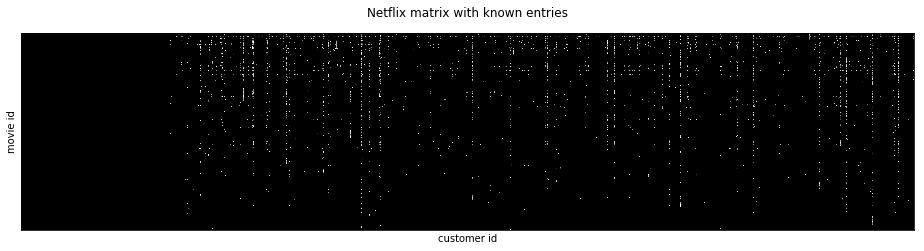

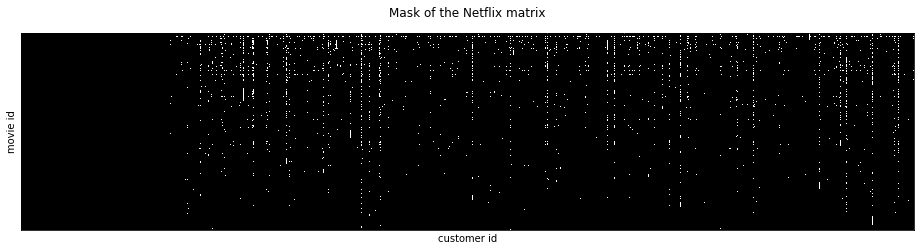

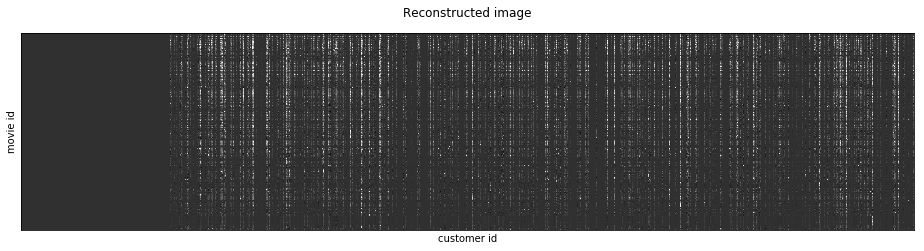

In [205]:
# get the values and the indexes of the known entries
B_dense = B_sparse.todense()
mask_dense = mask.todense()
omegaval = np.where(mask_dense!=0)
omega = np.argwhere(mask_dense!=0)
m, n = B_dense.shape

# define the unidimensional vector B with the known entries
B = np.squeeze(np.asarray(B_dense[omegaval]))
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
draw_mat(B_dense.T, "Netflix matrix with known entries", ylabel="movie id", xlabel="customer id")
draw_mat(mask_dense.T, "Mask of the Netflix matrix", ylabel="movie id", xlabel="customer id")
# run the DRS algorithm
rec = DRS(A, m, n, iterations = 200, gamma = .75).reshape(m, n)
# plot the reconstructed image
draw_mat(rec.T,"Reconstructed image", ylabel="movie id", xlabel="customer id")

In [203]:
#print(m,n)
#print(rec.shape)

### Bonus -- validation of the predictions
What we can do now is to validate the predicted ratings by selecting a few random known entries form our netflix matrix and moving them to a validation set. We can then try to see how well the predicted recommendation matches with the validation set.

In [173]:
def training_validaton_split(B, omega,validation_size):
    """
    splits the available data into a training and a validation set. Concretely this means that
    we take randomly selected known ratings from the netflix matrix and put them into our validation set
    
    Input:
        B: the constructed netflix matrix.
        omega: the index set of known entries in B.
        validation_size: the size of the validation set, i.e. how many known ratings we want to select.
        
    Output:
        B_train: the netflix matrix without the randomly selected entries.
        validation_ratings: a list of tuples of the form (customer_id, movie_id, rating)
    """
    
    B_train = copy.deepcopy(B)
    validation_ratings = []
    
    rints = np.random.randint(len(omega), size=validation_size)
    indices = omega[rints]    

    for i in range(validation_size):
        customer_id, movie_id = indices[i]
        rating = B[customer_id, movie_id]
        validation_ratings.append((customer_id, movie_id, rating))
        
        B_train[customer_id, movie_id] = 0
    
    return B_train, validation_ratings

B shape :  (3459,)
A shape:  (3459, 318265)


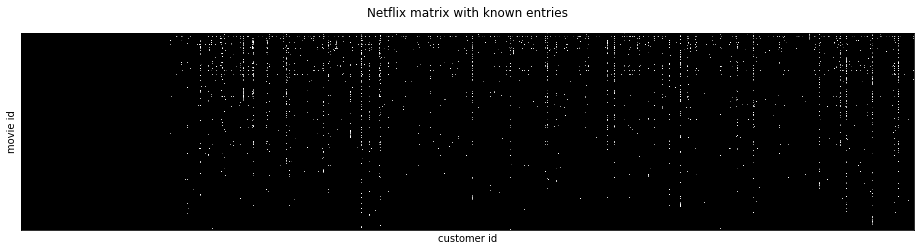

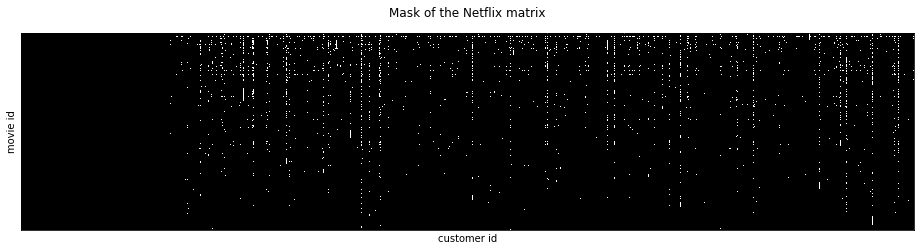

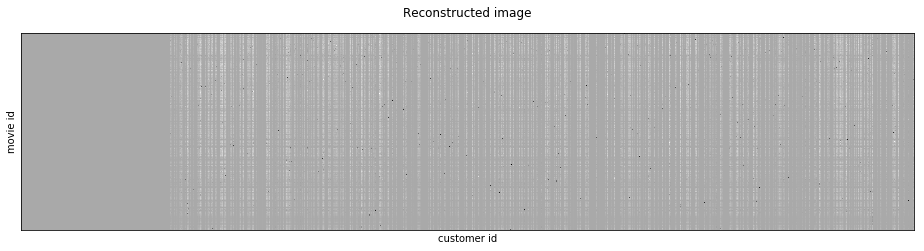

In [207]:
B_train, validation_ratings = training_validaton_split(B_dense, omega, validation_size=100)

# define the unidimensional vector B with the known entries
B = np.squeeze(np.asarray(B_train[omegaval]))
# sanity check
print ("B shape : ", B.shape)
# construct the matrix A, that encodes the known entries
A = construct_A(omega, m, n)
# sanity check
print ("A shape: ", A.shape)

# plot the noisy image
draw_mat(B_train.T, "Netflix matrix with known entries", ylabel="movie id", xlabel="customer id")
draw_mat(mask_dense.T, "Mask of the Netflix matrix", ylabel="movie id", xlabel="customer id")
# run the DRS algorithm
rec = DRS(A, m, n, iterations = 100, gamma = 20).reshape(m, n)
# plot the reconstructed image
draw_mat(rec.T,"Reconstructed image", ylabel="movie id", xlabel="customer id")



In [210]:
def get_loss(rec, validation_ratings):
    loss = 0.0
    for customer_id, movie_id, rating in validation_ratings:
        predicted_rating = rec[customer_id, movie_id]
        loss += np.abs(predicted_rating - rating)
    return loss/len(validation_ratings)
#print(get_loss(rec, validation_ratings))        
        #print(customer_id, movie_id, rating)
        #print(np.round(recommendations[customer_id, movie_id]), rating)
        
        
    

1.9072979138013941


1


TypeError: t() takes 1 positional argument but 2 were given